<a href="https://colab.research.google.com/github/arizky012/Deep-Learning/blob/master/03A_ResNext50_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf

from google.colab import drive

from os import listdir

from keras import backend as K
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

from keras_applications.resnext import ResNeXt50

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
%cd drive/'My Drive'/dataset

/content/drive/My Drive/dataset


In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((224, 224))
image_size = 0
directory_root = './covid-19/'

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("Loading covid-19 images ..")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for virus_folder in root_dir :
        virus_disease_folder_list = listdir(f"{directory_root}/{virus_folder}")
        
        for disease_folder in virus_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                virus_disease_folder_list.remove(disease_folder)

        for virus_disease_folder in virus_disease_folder_list:
            print(f"Processing: {virus_disease_folder} ..")
            virus_disease_image_list = listdir(f"{directory_root}/{virus_folder}/{virus_disease_folder}/")
                
            for single_virus_disease_image in virus_disease_image_list :
                if single_virus_disease_image == ".DS_Store" :
                    virus_disease_image_list.remove(single_virus_disease_image)

            for image in virus_disease_image_list[:200]:
                image_directory = f"{directory_root}/{virus_folder}/{virus_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(virus_disease_folder)
    print("Image loading completed.")  
except Exception as e:
    print(f"Error : {e}")

Loading covid-19 images ..
Processing: covid ..
Processing: normal ..
Image loading completed.


In [0]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
print("Normalizing data ..")
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

Normalizing data ..


In [0]:
print("Spliting data to training data and testing data ..")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 32) 
print("Splitting completed.")

Spliting data to training data and testing data ..
Splitting completed.


In [0]:
print(image_size)

148


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
#base model
resnext = ResNeXt50(input_tensor=Input(shape = (224, 224, 3)), include_top = False, weights = None, 
        backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

#top layer
#toplayer = Dense(n_classes, activation='softmax')(GlobalAveragePooling2D()(resnext.output))
x = resnext.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
toplayer = Dense(1, activation='softmax')(x)

#joining base model and top layer
model = Model(inputs=resnext.input, outputs=toplayer)

In [0]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS), metrics=["accuracy"])

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/100
7/7 [==============================] - 5s 667ms/step - loss: 5.8815 - accuracy: 0.5980 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 2/100
7/7 [==============================] - 5s 645ms/step - loss: 6.9902 - accuracy: 0.5196 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 3/100
7/7 [==============================] - 4s 642ms/step - loss: 7.5116 - accuracy: 0.5392 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 4/100
7/7 [==============================] - 4s 640ms/step - loss: 6.2197 - accuracy: 0.5882 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 5/100
7/7 [==============================] - 5s 689ms/step - loss: 6.2976 - accuracy: 0.5893 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 6/100
7/7 [==============================] - 4s 596ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 7/100
7/7 [==============================] - 5s 687ms/step - loss: 6.2976 - accuracy: 0.5893 - val_loss: 8.6412 - val_accuracy: 0.4333
Epoch 8/100
7

In [0]:
# Save the moel as a pickle in a file 
joblib.dump(model, 'ResNeXt50-covid-19.pkl')

['ResNeXt50-covid-19.pkl']

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

30/30 [==============================] - 1s 18ms/step
Test Accuracy: 43.33333373069763


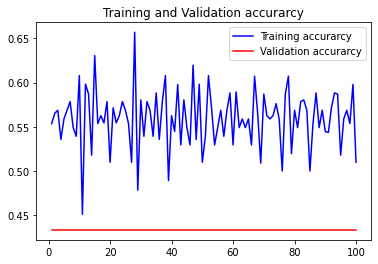

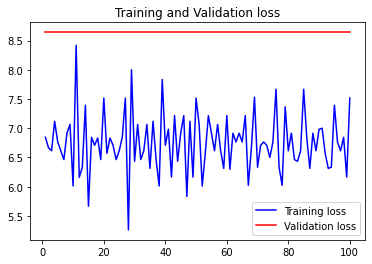

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()